In [1]:
import numpy as np
import tensorflow as tf
import h5py
from tensorflow import keras, Tensor
from tensorflow.keras import layers, callbacks
from tensorflow.keras.constraints import UnitNorm
import pandas as pd

In [45]:
latent_dim = 128
k_dim = 16
weights_file_vae = f'./weights/latent_{latent_dim}/weights.ckpt'
weights_file_dim = f'./weights_dim/k_{k_dim}/checkpoint.ckpt' 

In [46]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def reconstruct(self, data):
        z_mean, z_log_var, z = encoder(data)
        reconstruction = decoder(z)
        return reconstruction
    
    def extract_z_values(self, data):
        return encoder(data)[2]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [47]:
# Encoder and Decoder declared with functional API to save all the weights together
encoder_inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(64, kernel_size=4, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(128, kernel_size=4, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(512, kernel_size=4, activation="relu", strides=2, padding="same")(x)
encoded = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(encoded)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(encoded)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 16, 16, 64)   3136        input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 8, 8, 128)    131200      conv2d_35[0][0]                  
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 4, 4, 512)    1049088     conv2d_36[0][0]                  
____________________________________________________________________________________________

In [48]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(2048)(latent_inputs)
x = layers.Reshape((4, 4, 128))(x)
x = layers.Conv2DTranspose(256, kernel_size=4, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, kernel_size=4, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, kernel_size=4, activation="relu", strides=2, padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              264192    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 256)         524544    
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 16, 16, 64)        262208    
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 32, 32, 3)         3075      
Total params: 1,054,019
Trainable params: 1,054,019
Non-trainable params: 0
_________________________________________________

In [49]:
def relu_bn(inputs: Tensor) -> Tensor:
    relu = layers.ReLU()(inputs)
    bn = layers.BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = layers.Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = layers.Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = layers.Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = layers.Add()([x, y])
    out = relu_bn(out)
    return out

def create_res_net():
    
    inputs = keras.Input(shape=(32, 32, 6))
    num_filters = 64
    
    t = layers.BatchNormalization()(inputs)
    t = layers.Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    
    num_blocks_list = [2, 5, 5, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2
    
    t = layers.AveragePooling2D(4)(t)
    t = layers.Flatten()(t)
    outputs_k = layers.Dense(k_dim, activation='softmax')(t)
    outputs_e = layers.Dense(1)(t)
    
    model = keras.Model(inputs, [outputs_k, outputs_e])

    return model

# The model to take the error, direction and z value and output the two inputs for the generator
direction_input = keras.Input(shape=(k_dim))
error_input = keras.Input(shape=(1))
z_input = keras.Input(shape=(latent_dim))
pre_a = layers.Multiply()([direction_input, error_input])
post_a = layers.Dense(latent_dim, use_bias= False, kernel_constraint = UnitNorm(axis = 1))(pre_a)
perturbed_out = layers.Add()([post_a, z_input])
model_A = keras.Model([direction_input, error_input, z_input], perturbed_out)
model_A.summary()

# The model or the reconstructor which takes two images, concataned in axis 3
reconstructor = create_res_net()

#%%
class DimensionDiscover(keras.Model):
    def __init__(self, model_A, decoder, model_R, **kwargs):
        super(DimensionDiscover, self).__init__(**kwargs)
        self.decoder = decoder
        self.model_A = model_A
        self.model_R = model_R

    def reconstruct(self, data):
        z_mean, z_log_var, z = encoder(data)
        reconstruction = decoder(z)
        return reconstruction

    def call(self, data, training=False):
        if isinstance(data, tuple):
            data = data[0]
        reconstruction = decoder(z)
        return reconstruction

    def train_step(self, data):
        directions, err, z = data
        with tf.GradientTape() as tape_r, tf.GradientTape() as tape_a:
            pert_out = self.model_A((directions, err, z))
            reconstruction = decoder(z)
            reconstruction_pert = decoder(pert_out)
            r_input = tf.concat([reconstruction, reconstruction_pert], axis = 3)
            out_k, out_e = self.model_R(r_input)
            k_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(directions, out_k)
            )
            e_loss = tf.reduce_mean(
                keras.losses.MeanAbsoluteError()(err, out_e)
            )
            total_loss = k_loss + e_loss * 0.25

            grads_r = tape_r.gradient(total_loss, self.model_R.trainable_weights)
            grads_a = tape_a.gradient(total_loss, self.model_A.trainable_weights)

            self.optimizer[0].apply_gradients(zip(grads_r, self.model_R.trainable_variables))
            self.optimizer[1].apply_gradients(zip(grads_a, self.model_A.trainable_variables))
        return {
            "loss": total_loss,
            "dimension_loss": k_loss,
            "noise_loss": e_loss,
        }

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
multiply_1 (Multiply)           (None, 16)           0           input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 128)          2048        multiply_1[0][0]      

In [50]:
test_file = '../data/camelyonpatch_level_2_split_test_x.h5'
test_x = h5py.File(test_file, 'r', libver='latest', swmr=True)['x']

In [51]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.load_weights(weights_file_vae)
dd = DimensionDiscover(model_A, vae.decoder, reconstructor)
dd.compile(optimizer=[keras.optimizers.Adam(learning_rate=0.0001), keras.optimizers.Adam(learning_rate=0.0001)])
dd.load_weights(weights_file_dim)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


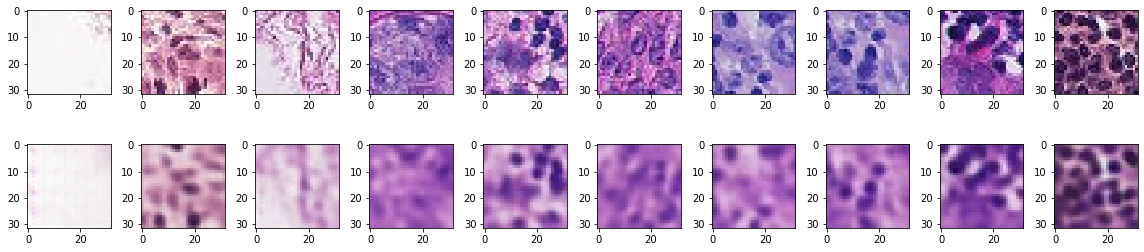

In [52]:
# display results
import matplotlib.pyplot as plt

n_rec = 10

x_batch = test_x[0:n_rec,:32,:32] / 255.

plt.figure(figsize=(n_rec+6,4))

pred_img = vae.reconstruct(x_batch)

for i in range(n_rec):
    
    plt.subplot(2, n_rec, i+1)
    plt.imshow(x_batch[i])

    plt.subplot(2, n_rec, n_rec+i+1)
    plt.imshow(pred_img[i])

plt.tight_layout()

### Latent Space Analysis
Below we are selecting a subset of 5000 images to do pca on the latent space and inspect the PCs with the biggest variance. 
#### Remarks: 
- In an ideal case the KL-Divergence term approaches 0, which means the latent space will have a spherical variance. But with the training with lesser latent dimensions, there's always some unnormalized variances left, which we can use to do pca and get the strongest components
- The first cell with interact just initializes 10 images with z value 0, and then adds noise to one of the latent dimensions, the number of the dimension does not matter here, as it does not resemble any importance. The top left image is the result of negative value added to that dimension in z space, bottom right is positive
- The second cell with interact employs pca to add the noise, which will result in changes in the most deviating components, the number of components matter in this case, as the #0 is the strongest
- Currently not sure that if PCA is supposed to do anything informative here, if there's no linear correlation in the latent space, it might be useless. But we can keep it as a Proof of Concept, and try other approaches in the future

In [53]:
# A subset of 5000 images is selected here
z_vals = vae.extract_z_values(test_x[:5000,32:64,32:64] / 255.).numpy().squeeze()

#### Dimension Discovery based on https://arxiv.org/pdf/2002.03754.pdf

In [54]:
directions = model_A.layers[3].weights[0].numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

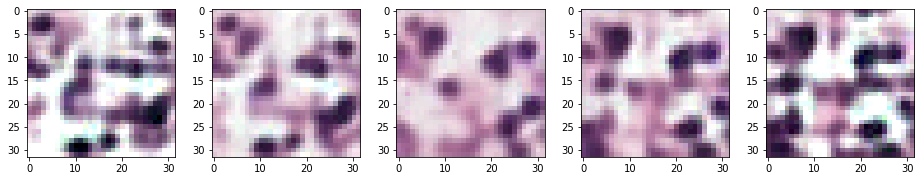

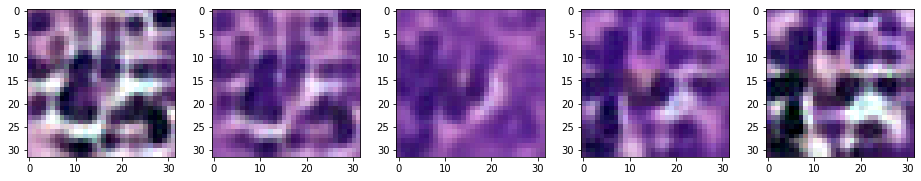

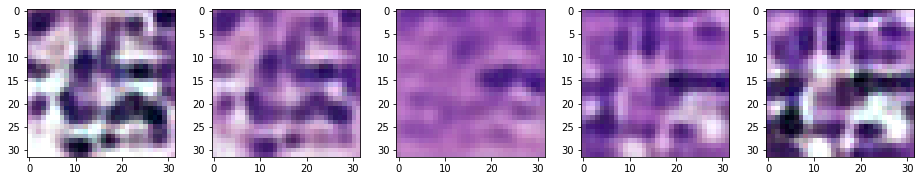

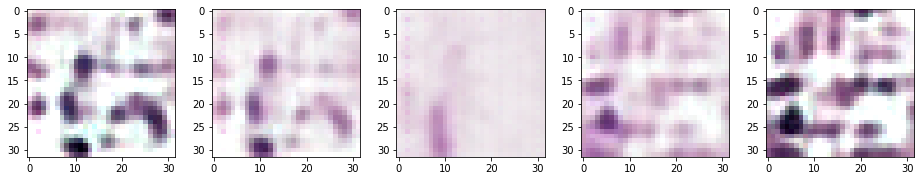

In [58]:
def visualize_k_dim(k_num, image_index):
    #z_values = np.zeros((10,128))
    z_values = np.repeat(z_vals[image_index][:,np.newaxis], 5, axis=1).T
    #z_values = np.random.normal(z_vals.mean(axis=0),z_vals.std(axis=0),(5,128))
    linear_noise =  np.linspace(-6,6,5)
    z_values += (directions[k_num] * linear_noise.reshape(5,1))
    generated = decoder(z_values)
    plt.figure(figsize=(n_rec+6,6))

    for i in range(5):

        plt.subplot(2, n_rec/2, i+1)
        plt.imshow(generated[i])

k_num = 10
image_indices = np.random.choice(5000, 4)
for i in image_indices:
    visualize_k_dim(k_num, i)